In [ ]:
pip install --quiet torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 pytorch-tabnet==4.1.0

In [1]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())

2.6.0+cu124
CUDA available: True


In [2]:
# TabNet binary classifier 
%matplotlib inline
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
import joblib
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# Reproducibility 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


INPUT_PATH = "/kaggle/input/binary-ga/Binary GA.csv"
OUT_DIR = "/kaggle/working/Binary_TabNet"
os.makedirs(OUT_DIR, exist_ok=True)

# Parameters
LABEL_COL = "binary_label"
TEST_SIZE = 0.15
VAL_SIZE = 0.15
SAMPLE_FRACTION = 1.0
MAX_EPOCHS = 200
BATCH_SIZE = 256
LR = 2e-3
WEIGHT_DECAY = 1e-5
PATIENCE = 20
N_D = 24
N_A = 24
N_STEPS = 5
GAMMA = 1.3
VIRTUAL_BATCH_SIZE = 64

Preprocessing

Loading CSV...
Data shape: (10459, 9055)
Numeric features: 9054


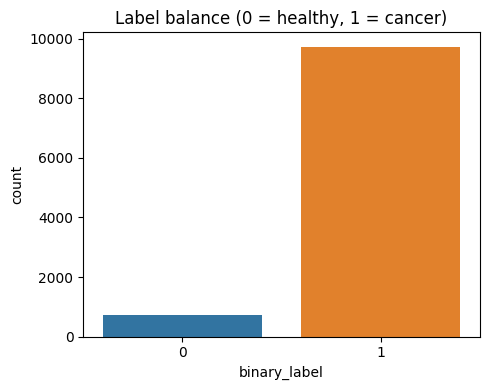

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


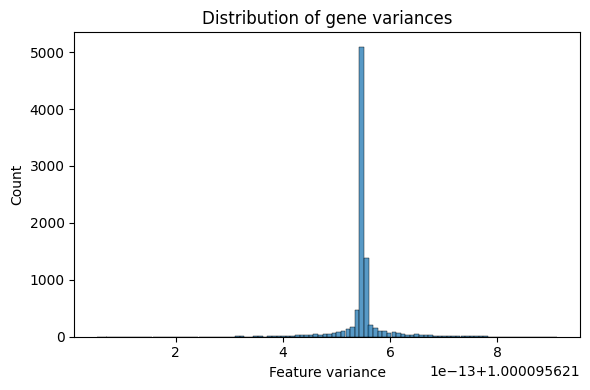

Running PCA (2 components) for quick visualization...


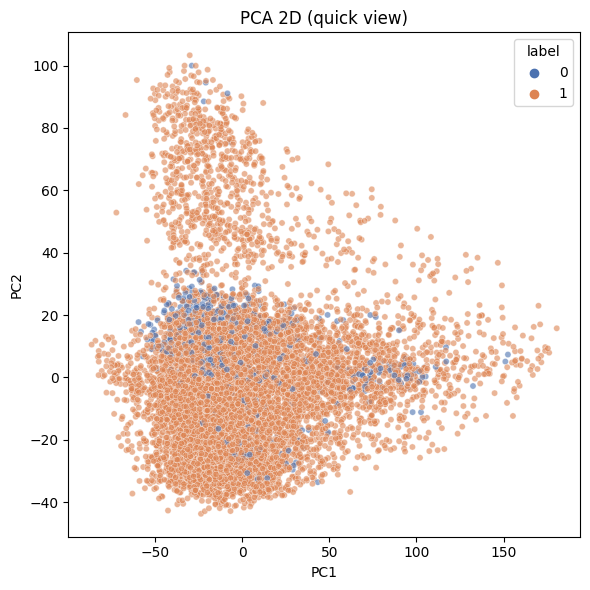

Train shape: (7321, 9054) Val shape: (1569, 9054) Test shape: (1569, 9054)
Train label dist: [ 509 6812]
Val label dist: [ 109 1460]
Test label dist: [ 109 1460]
Class weights: {0: 7.19155206286837, 1: 0.5373605402231356}


In [5]:
print("Loading CSV...")
df = pd.read_csv(INPUT_PATH, low_memory=False)
if SAMPLE_FRACTION < 1.0:
    df = df.sample(frac=SAMPLE_FRACTION, random_state=SEED)

print("Data shape:", df.shape)

if LABEL_COL not in df.columns:
    raise ValueError(f"Label column '{LABEL_COL}' not found in CSV. Edit LABEL_COL to match your file.")

y = df[LABEL_COL].astype(int).values
X = df.drop(columns=[LABEL_COL], errors="ignore")
X = X.select_dtypes(include=[np.number])
print("Numeric features:", X.shape[1])

# Impute NaNs if present
if X.isna().sum().sum() > 0:
    print("Imputing NaNs with column medians...")
    X = X.fillna(X.median())

# Visuals: label balance
plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Label balance (0 = healthy, 1 = cancer)")
plt.xlabel("binary_label")
plt.tight_layout()
plt.show()

# Visuals: feature variance histogram
feature_variances = X.var(axis=0)
plt.figure(figsize=(6,4))
sns.histplot(feature_variances, bins=100)
plt.xlabel("Feature variance")
plt.title("Distribution of gene variances")
plt.tight_layout()
plt.show()

# Visuals: PCA 2D
print("Running PCA (2 components) for quick visualization...")
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X.values))
plt.figure(figsize=(6,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="deep", alpha=0.6, s=20)
plt.title("PCA 2D (quick view)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="label")
plt.tight_layout()
plt.show()

# Train/validation/test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X.values, y, test_size=TEST_SIZE, stratify=y, random_state=SEED
)
val_fraction_of_temp = VAL_SIZE / (1.0 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_fraction_of_temp, stratify=y_temp, random_state=SEED
)
print("Train shape:", X_train.shape, "Val shape:", X_val.shape, "Test shape:", X_test.shape)
print("Train label dist:", np.bincount(y_train))
print("Val label dist:", np.bincount(y_val))
print("Test label dist:", np.bincount(y_test))

# Scaling (save the scaler)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# sample weights for imbalance
classes = np.unique(y_train)
cw = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, cw))
sample_weights = np.array([class_weight_dict[int(lbl)] for lbl in y_train], dtype=float)
print("Class weights:", class_weight_dict)

TabNet Model

In [8]:
# TabNet model
clf = TabNetClassifier(
    n_d=N_D,
    n_a=N_A,
    n_steps=N_STEPS,
    gamma=GAMMA,
    lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=LR, weight_decay=WEIGHT_DECAY),
    mask_type="entmax",
    scheduler_params={"step_size": 20, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=10,  # set >0 for visible progress
    seed=SEED
)

# Training 
print("\nStarting training...")
use_gpu = torch.cuda.is_available()
print("Using GPU?", use_gpu)

clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=["train", "val"],
    eval_metric=["auc"],
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    batch_size=BATCH_SIZE,
    virtual_batch_size=VIRTUAL_BATCH_SIZE,
    weights=sample_weights,
    drop_last=False,
)

# Evaluation
val_preds = clf.predict(X_val)
val_probs = clf.predict_proba(X_val)[:,1]
test_preds = clf.predict(X_test)
test_probs = clf.predict_proba(X_test)[:,1]

val_acc = accuracy_score(y_val, val_preds)
test_acc = accuracy_score(y_test, test_preds)
val_auc = roc_auc_score(y_val, val_probs)
test_auc = roc_auc_score(y_test, test_probs)

print(f"Validation Accuracy: {val_acc:.4f}  AUC: {val_auc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}  AUC: {test_auc:.4f}")
print("\nClassification report (test):")
print(classification_report(y_test, test_preds, digits=4))

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")



Starting training...
Using GPU? True
epoch 0  | loss: 0.87392 | train_auc: 0.5488  | val_auc: 0.57926 |  0:00:06s
epoch 10 | loss: 0.53569 | train_auc: 0.89082 | val_auc: 0.88507 |  0:01:09s
epoch 20 | loss: 0.38335 | train_auc: 0.94247 | val_auc: 0.95247 |  0:02:13s
epoch 30 | loss: 0.29325 | train_auc: 0.96691 | val_auc: 0.973   |  0:03:16s
epoch 40 | loss: 0.22671 | train_auc: 0.97984 | val_auc: 0.98491 |  0:04:19s
epoch 50 | loss: 0.18996 | train_auc: 0.98725 | val_auc: 0.99132 |  0:05:23s
epoch 60 | loss: 0.12003 | train_auc: 0.99648 | val_auc: 0.99541 |  0:06:27s
epoch 70 | loss: 0.07912 | train_auc: 0.9987  | val_auc: 0.99267 |  0:07:30s
epoch 80 | loss: 0.0476  | train_auc: 0.99884 | val_auc: 0.99666 |  0:08:33s
epoch 90 | loss: 0.02397 | train_auc: 0.99982 | val_auc: 0.9987  |  0:09:37s
epoch 100| loss: 0.01596 | train_auc: 0.99987 | val_auc: 0.99833 |  0:10:40s
epoch 110| loss: 0.01355 | train_auc: 0.99998 | val_auc: 0.99839 |  0:11:44s

Early stopping occurred at epoch 114 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Validation Accuracy: 0.9885  AUC: 0.9991
Test Accuracy:       0.9866  AUC: 0.9882

Classification report (test):
              precision    recall  f1-score   support

           0     0.8793    0.9358    0.9067       109
           1     0.9952    0.9904    0.9928      1460

    accuracy                         0.9866      1569
   macro avg     0.9372    0.9631    0.9497      1569
weighted avg     0.9871    0.9866    0.9868      1569



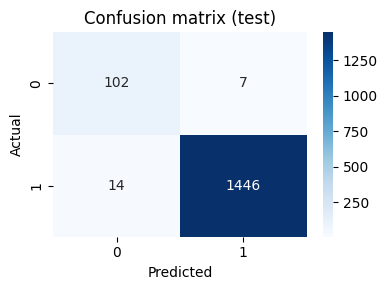

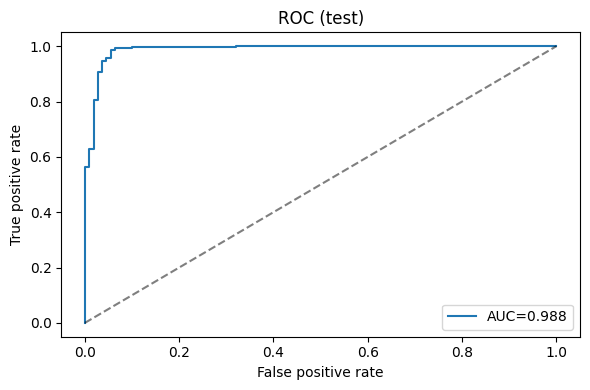

Successfully saved model at /kaggle/working/Binary_TabNet/tabnet_binary_model.zip.zip
Saved TabNet model: /kaggle/working/Binary_TabNet/tabnet_binary_model.zip


In [10]:
# Confusion matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion matrix (test)")
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}")
plt.plot([0,1],[0,1],"k--", alpha=0.5)
plt.xlabel("False positive rate"); plt.ylabel("True positive rate")
plt.title("ROC (test)")
plt.legend()
plt.tight_layout()
plt.show()

# Save model 
MODEL_PATH = os.path.join(OUT_DIR, "tabnet_binary_model.zip")

# save TabNet model (.zip)
clf.save_model(MODEL_PATH)
print("Saved TabNet model:", MODEL_PATH)